> # Бајесова анализа на финансиски податоци од берзата на САД
> #### Јован Крајевски (199015)
> ##### јуни, 2022

## Собирање на податоци од берзата на САД

In [1]:
import yfinance
import time
import pandas as pd
from pathlib import Path

indexes = ["^GSPC"]

OVERWRITE_ANYWAY = False

DATA_LOCATION = Path(".") / "data"
DATA_LOCATION.mkdir(exist_ok=True, parents=True)

start_time = time.time()

if OVERWRITE_ANYWAY or not (DATA_LOCATION / "indexes.pkl").is_file():
    daily_smp = yfinance.download(" ".join(indexes),
                                           period="max",
                                           interval="1d")
    daily_smp.to_pickle(DATA_LOCATION / "indexes.pkl")

daily_smp = pd.read_pickle(DATA_LOCATION / "indexes.pkl")

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

[*********************100%***********************]  1 of 1 completed
0.60s


In [2]:
daily_smp

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000
...,...,...,...,...,...,...
2022-05-23,3919.419922,3981.879883,3909.040039,3973.750000,3973.750000,3392770000
2022-05-24,3942.939941,3955.679932,3875.129883,3941.479980,3941.479980,3901640000
2022-05-25,3929.590088,3999.330078,3925.030029,3978.729980,3978.729980,4322190000


<IPython.core.display.Javascript object>


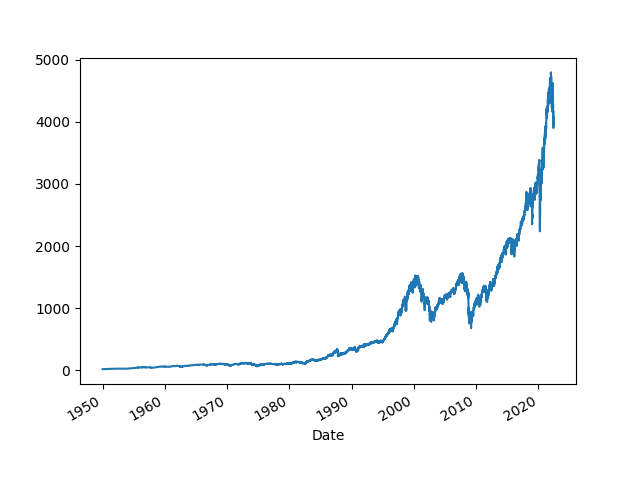

<AxesSubplot:xlabel='Date'>

In [3]:
%matplotlib notebook
daily_smp["Close"].plot()

# Поделба на податоците на тренирачко и тестирачко множество

In [4]:
train_smp = daily_smp[daily_smp.index < "01-01-2000"].copy()
test_smp = daily_smp[daily_smp.index >= "01-01-2000"].copy()
len(train_smp), len(test_smp)

(12582, 5638)

# Трансформации на податоците

In [7]:
import numpy as np

def transform_close(df):
    df["close"] = df["Close"]
    df["close_return"] = df["close"].pct_change(periods=1)
    df["close_diff"] = df["close"].diff(periods=1)
    df["close_log_return"] = np.log(df["close"]) - np.log(df["close"].shift(1))
    df = df.dropna()
    
transform_close(train_smp)
transform_close(test_smp)

<IPython.core.display.Javascript object>


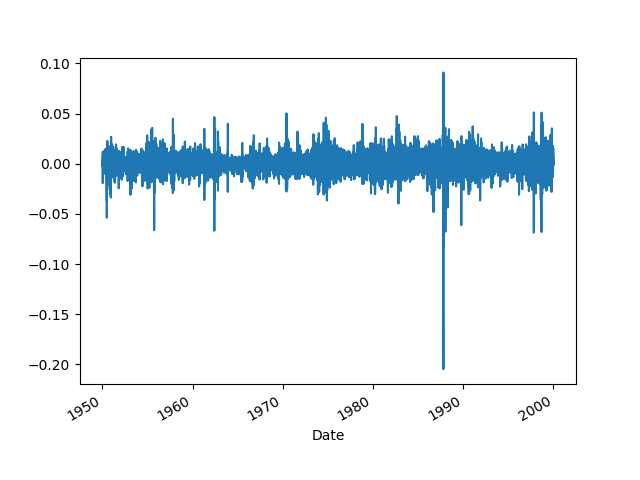

<AxesSubplot:xlabel='Date'>

In [9]:
train_smp["close_return"].plot()

<IPython.core.display.Javascript object>


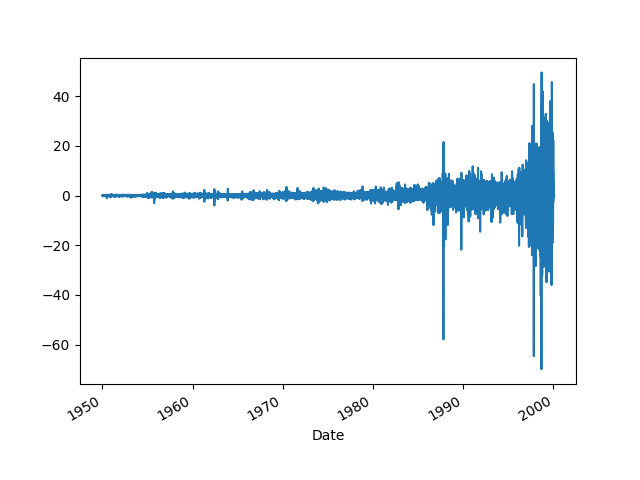

<AxesSubplot:xlabel='Date'>

In [10]:
train_smp["close_diff"].plot()

<IPython.core.display.Javascript object>


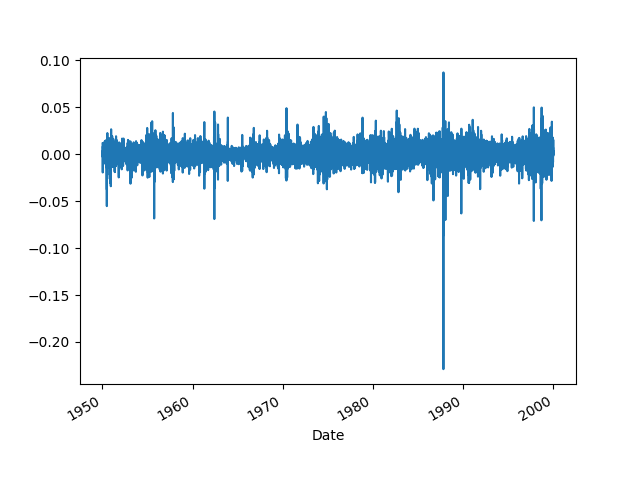

<AxesSubplot:xlabel='Date'>

In [11]:
train_smp["close_log_return"].plot()

# Стационарност